In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import pandas as pd
from Code.Tutorial.Dataset  import load_scg

import neurokit2 as nk
import warnings
from tqdm import tqdm
from scipy.signal import find_peaks
warnings.filterwarnings("ignore")

In [107]:
def load_Simulated_Data(type, num=35, duration=10, sampling_rate=100, seed=0):
    np.random.seed(seed)
    hr_low = 50
    hr_up = 90
    hr = np.random.randint(hr_low, hr_up + 1, size=num)
    scrs = np.random.randint(3, 10, size=num)
    print(hr)
    signals = []
    if type == 'ecg':
        for i in tqdm(range(num)):
            ecg = nk.ecg_simulate(duration=duration, sampling_rate=sampling_rate, heart_rate=hr[i])
            signals.append(nk.ecg_clean(ecg, sampling_rate=sampling_rate))
    elif type == 'ppg':
        for i in tqdm(range(num)):
            ppg = nk.ppg_simulate(duration=duration, sampling_rate=sampling_rate, heart_rate=hr[i])
            signals.append(nk.ppg_clean(ppg, sampling_rate=sampling_rate))
    elif type == 'eda':
        for i in tqdm(range(num)):
            eda = nk.eda_simulate(duration=duration, sampling_rate=sampling_rate, scr_number=scrs[i])
            signals.append(nk.eda_clean(eda, sampling_rate=sampling_rate))
    elif type == 'scg':
        signals_train, labels_train, _, _ = load_scg(0, 'train')

        signals_train_ls = []
        labels_train_ls = []

        for cnt, signal in enumerate(signals_train[:num*2]):
            if max(signal) > 1:
                continue
            signals_train_ls.append(signal)
            labels_train_ls.append(labels_train[cnt])

        signals = signals_train_ls[:num]
        labels = labels_train_ls[:num]
        hr = np.array(labels)[:, 2]

    return np.array(signals), np.array(hr)


In [66]:
def segmentation(signals, envelopes, hrs, alpha):

    show = False
    all_pieces = []
    for cnt in range(len(signals)):

        envelope = envelopes[cnt]
        hr = hrs[cnt]
        signal = signals[cnt]
        peaks_temp, _ = find_peaks(envelope, height=np.max(envelope) * 0.15, distance=(5500 // hr))
        initial_dis = np.int(np.mean(np.diff(peaks_temp)) / 2)
        peaks_dis_mean = np.int(np.mean(np.diff(peaks_temp)))

        peaks, _ = find_peaks(envelope, height=np.max(envelope) * alpha, distance=(5000 // hr))

        if show:
            plt.figure(figsize=(12, 3))
            plt.plot(envelope)
            plt.plot(signal)
            plt.scatter(peaks ,envelope[peaks])
            plt.show()

        diff_peaks = np.diff(peaks)

        pieces = []

        for i in range(len(diff_peaks)):
            if i == 0:
                if peaks[i] < initial_dis:
                    continue
                else:
                    start = peaks[i] - initial_dis
                    end = (peaks[i] + peaks[i+1]) // 2
                    piece  = signal[start: end]
                    pieces.append(piece)
            else:
                if peaks[i] - peaks[i-1] > peaks_dis_mean * 1.2:
                    start = peaks[i] - initial_dis
                else:
                    start = (peaks[i-1] + peaks[i]) // 2

                if peaks[i+1] - peaks[i] > peaks_dis_mean * 1.2:
                    end = peaks[i] + initial_dis
                else:
                    end = (peaks[i] + peaks[i+1]) // 2
                piece = signal[start: end]
                pieces.append(piece)
        # print(len(pieces), len(peaks))

        all_pieces.append(pieces)

        if show:
            plt.figure(figsize=(12, 3))
            for line, piece in enumerate(pieces):
                plt.plot(piece, label=str(line))
            plt.legend()
            plt.show()
    return all_pieces

In [67]:
# # energy
def cal_energy(signals, window=32):
    show = False
    energies = []
    for cnt in range(len(signals)):
        signal = signals[cnt]

        signal_padded = np.pad(signal, [window//2, window//2], 'constant', constant_values=(0, 0))

        squared_signal = np.square(signal_padded)

        start = 0
        end = 0
        signal_energy = []
        for i in range(len(signal_padded)-window):
            start = i
            end = i + window
            signal_energy.append(np.sum(squared_signal[start:end]) / window)

        energies.append(np.array(signal_energy))
        if show:
            plt.figure(figsize=(12, 3))
            plt.plot(signal)
            plt.plot(signal_energy)
            plt.show()
    return energies

In [82]:
def plot_segs(energies, good_signals, hrs, all_pieces_energy, alpha):
    for cnt, pieces in enumerate(all_pieces_energy):

        hr = hrs[cnt]
        signal = good_signals[cnt]
        envelope = energies[cnt]

        peaks2, _ = find_peaks(envelope, height=np.max(envelope) * alpha, distance=(5000 // hr))

        template = performDBA(pieces)

        plt.subplots(3, 1, figsize=(12, 7))
        plt.suptitle(str(cnt))

        plt.subplot(311)
        plt.plot(signal)
        plt.plot(envelope)
        # plt.scatter(peaks1, envelope[peaks1])

        plt.subplot(312)
        plt.plot(envelope)
        plt.scatter(peaks2, envelope[peaks2])

        plt.subplot(313)
        for piece in pieces:
            plt.plot(piece, alpha=0.35)
        plt.plot(template, color='r', linewidth=2, label='Template')
        plt.legend()

        plt.show()

In [85]:
ecgs, ecgs_hr = load_Simulated_Data('ecg')

[50 53 53 89 59 69 71 86 73 56 74 74 62 51 88 89 73 74 67 87 75 63 58 59
 70 66 55 65 50 68 85 74 79 69 69]


100%|██████████| 35/35 [00:07<00:00,  4.76it/s]


In [108]:

ppgs, ppgs_hr = load_Simulated_Data('ppg')

edas, edas_scrs = load_Simulated_Data('eda')

scgs, scgs_hrs = load_Simulated_Data('scg')

[50 53 53 89 59 69 71 86 73 56 74 74 62 51 88 89 73 74 67 87 75 63 58 59
 70 66 55 65 50 68 85 74 79 69 69]


100%|██████████| 35/35 [00:00<00:00, 186.06it/s]


[50 53 53 89 59 69 71 86 73 56 74 74 62 51 88 89 73 74 67 87 75 63 58 59
 70 66 55 65 50 68 85 74 79 69 69]


100%|██████████| 35/35 [00:00<00:00, 158.71it/s]

[50 53 53 89 59 69 71 86 73 56 74 74 62 51 88 89 73 74 67 87 75 63 58 59
 70 66 55 65 50 68 85 74 79 69 69]


In [87]:
from Code.DTW.dba.DBA import performDBA

sampling_rate = 100

ecg_energies = cal_energy(ecgs, window=8)
ecg_all_pieces_energy = segmentation(ecgs, ecg_energies, ecgs_hr, 0.5)
plot_segs(ecg_energies, ecgs, ecgs_hr, ecg_all_pieces_energy, 0.5)

TypeError: reduce() of empty sequence with no initial value

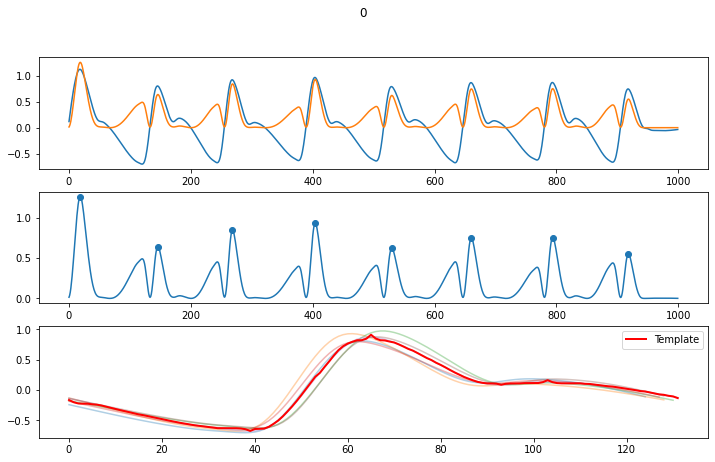

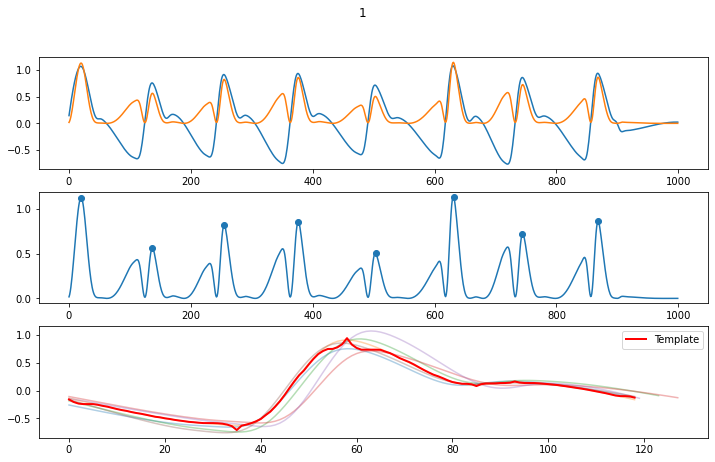

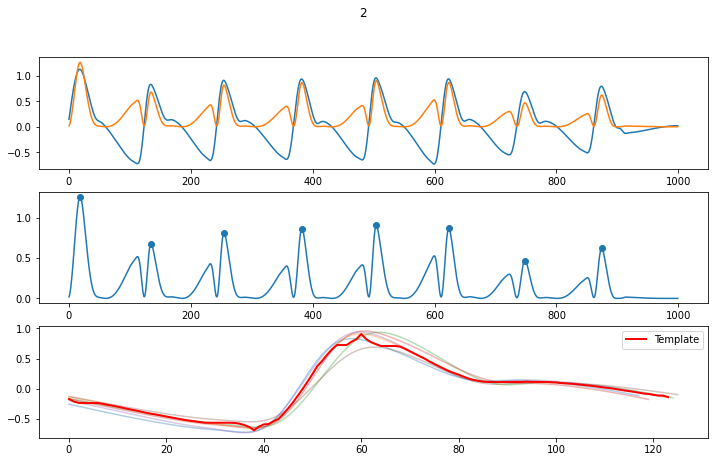

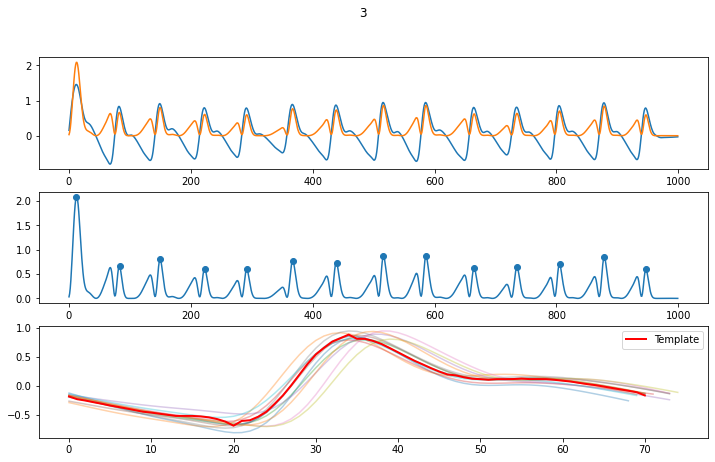

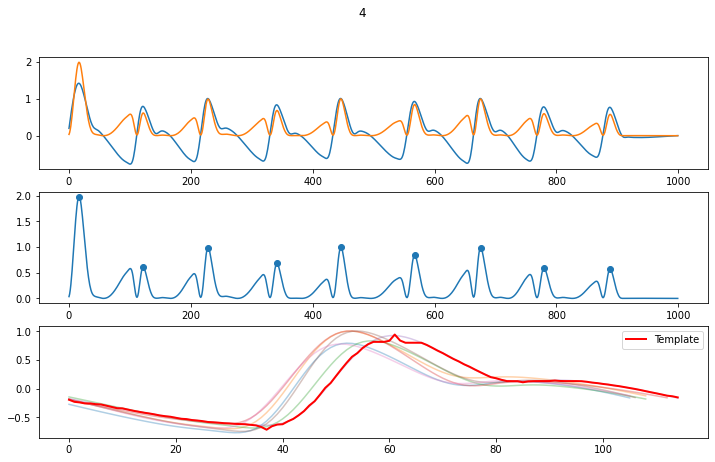

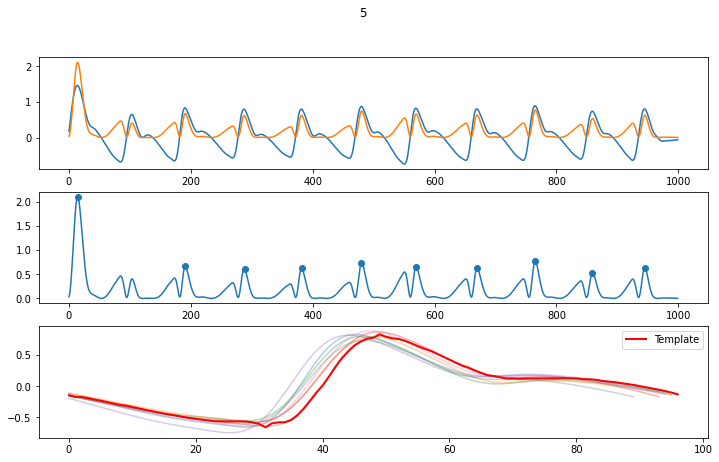

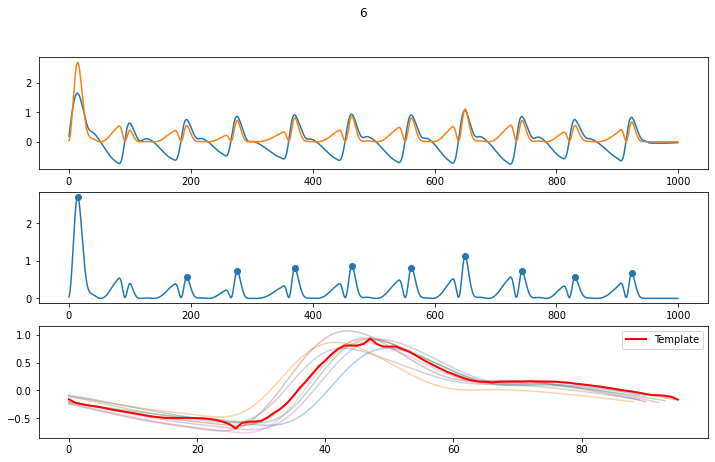

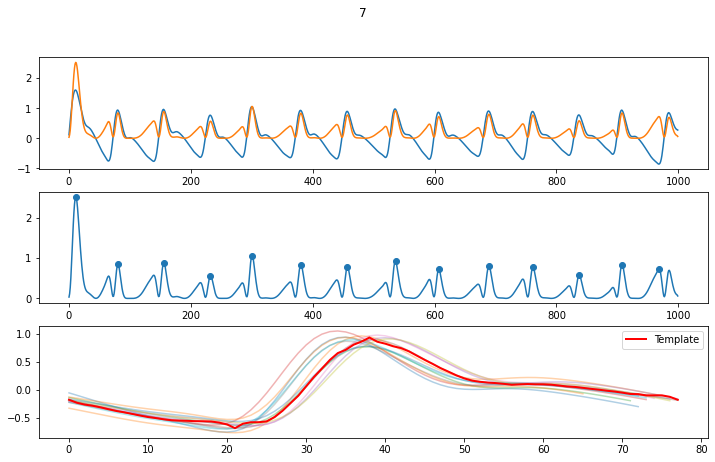

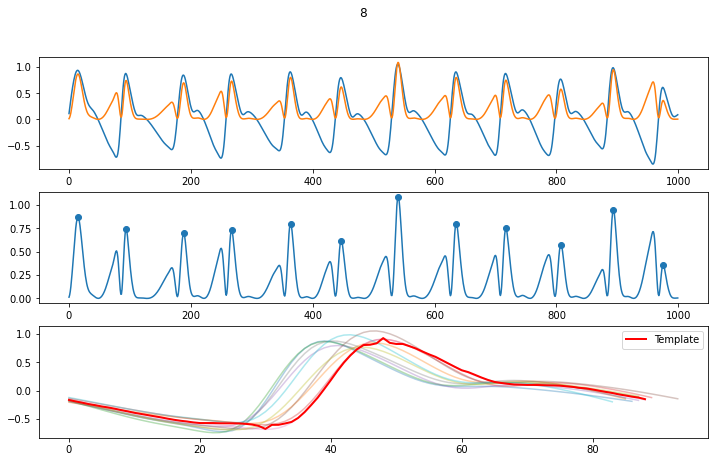

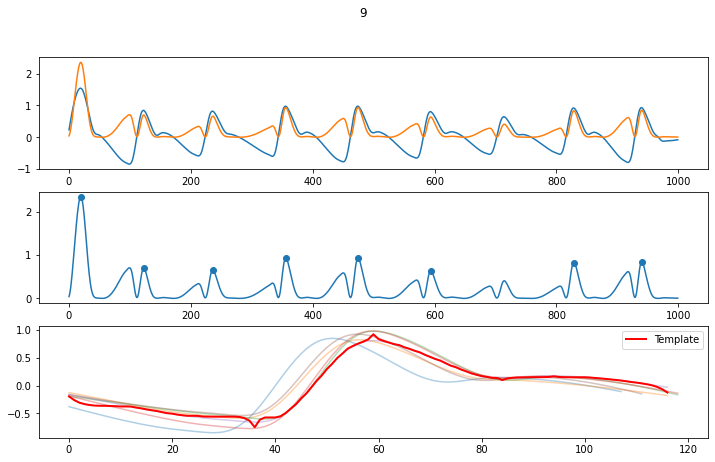

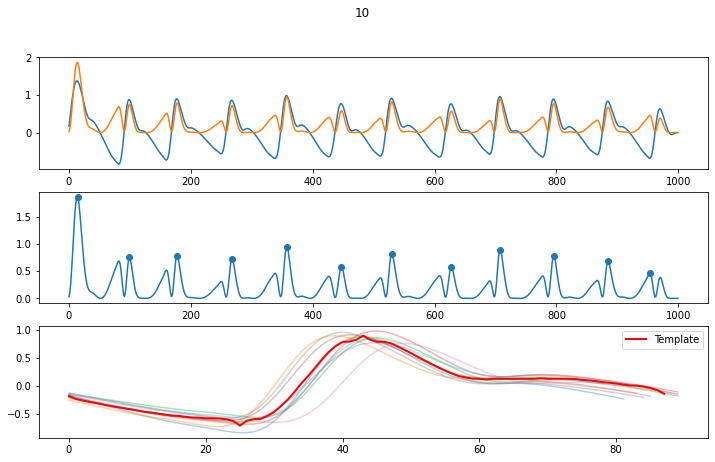

KeyboardInterrupt: 

In [91]:
ppg_energies = cal_energy(ppgs, window=4)
ppg_all_pieces_energy = segmentation(ppgs, ppg_energies, ppgs_hr, 0.2)
plot_segs(ppg_energies, ppgs, ppgs_hr, ppg_all_pieces_energy, 0.2)

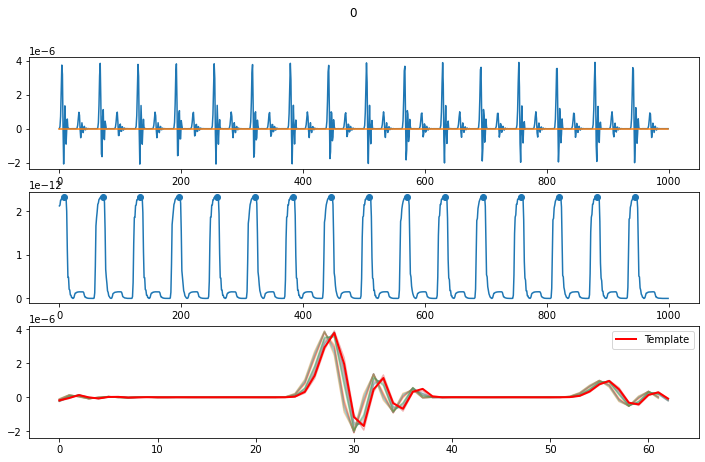

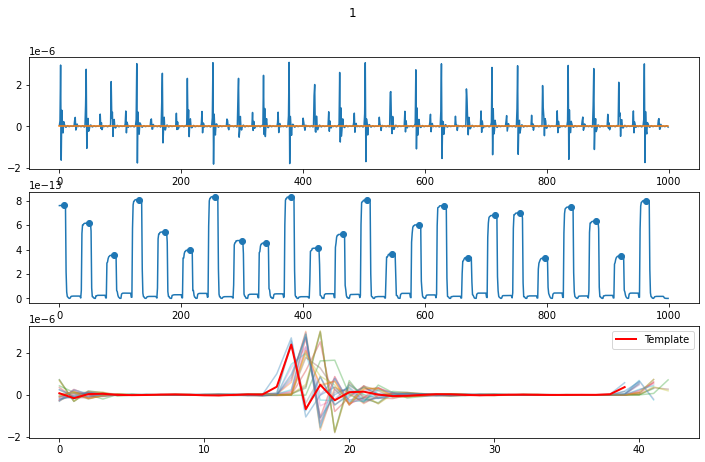

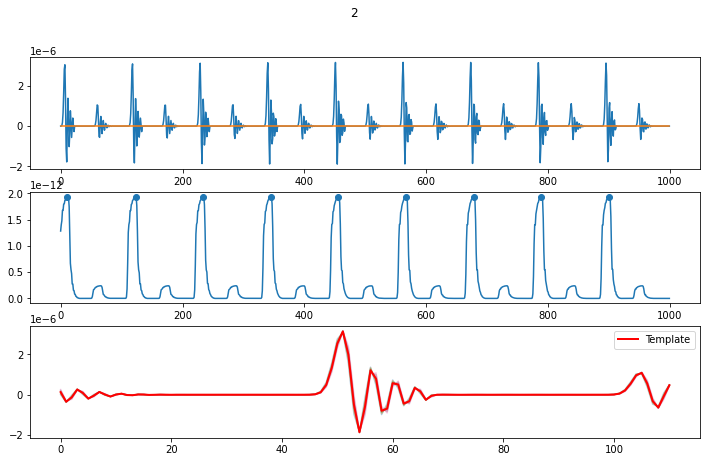

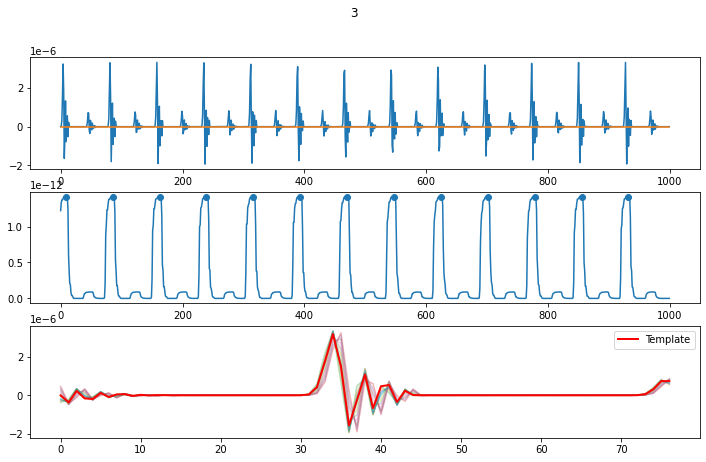

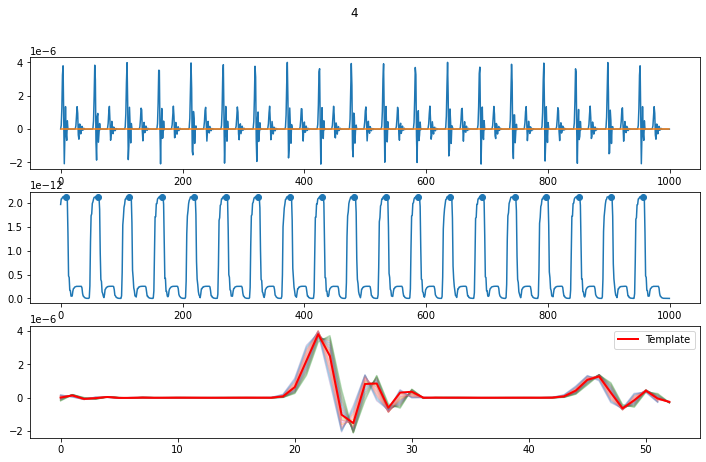

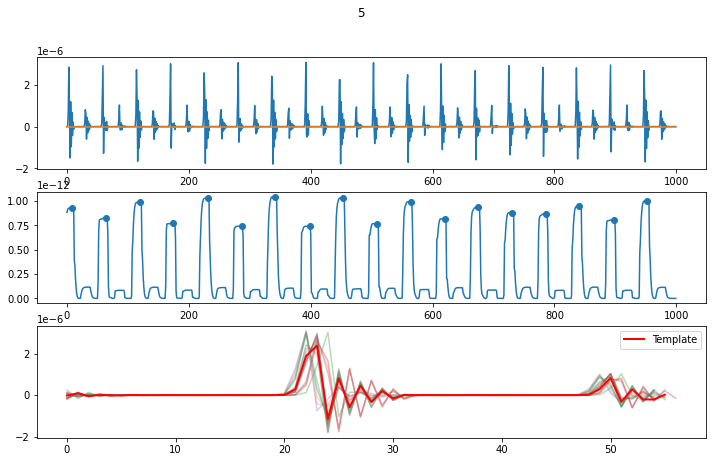

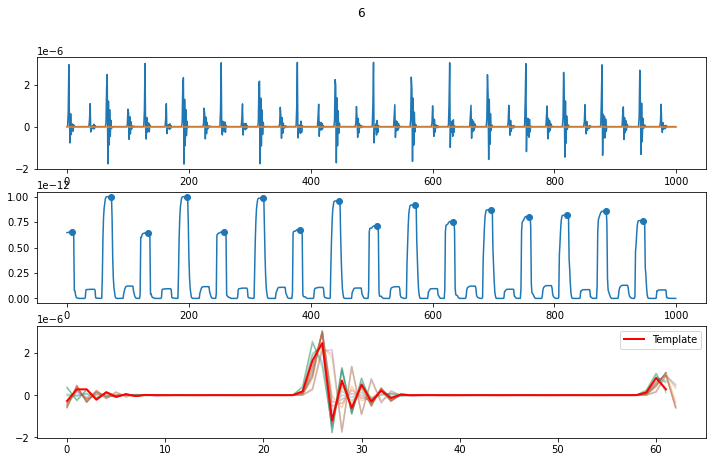

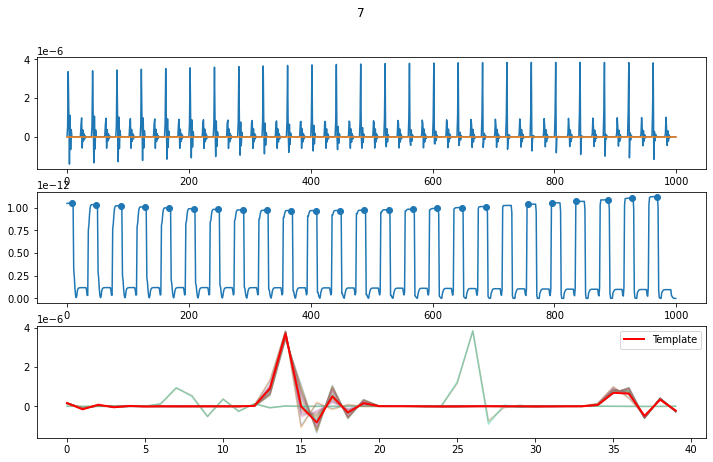

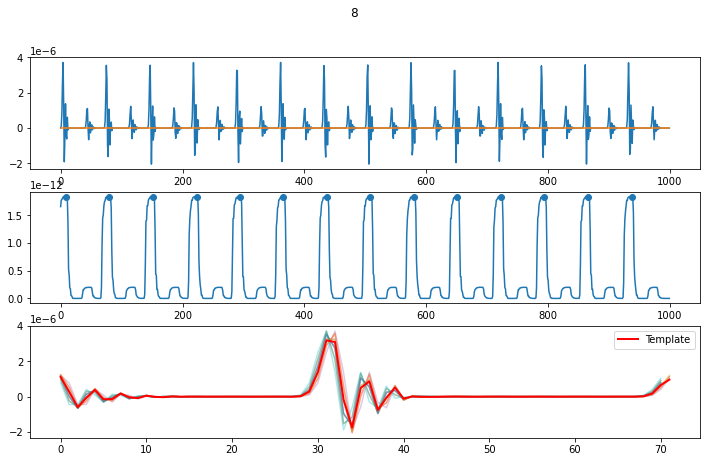

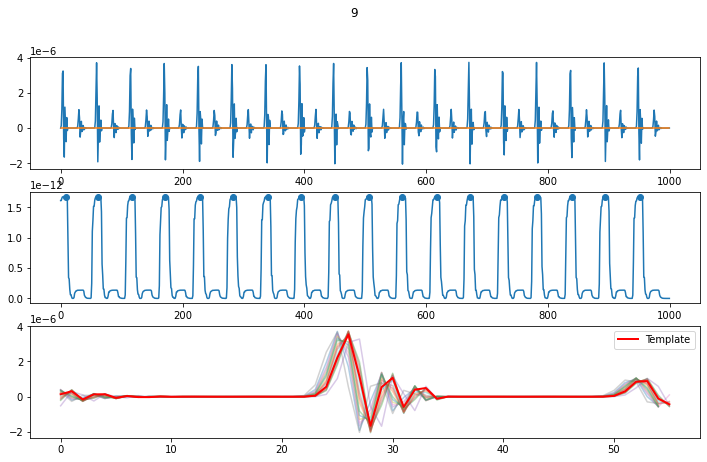

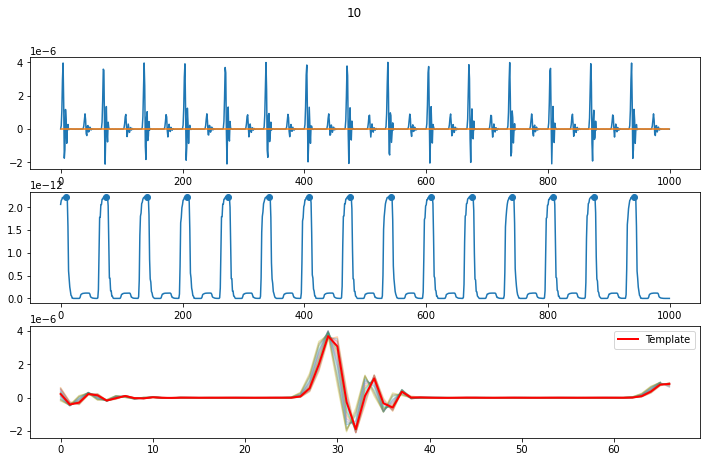

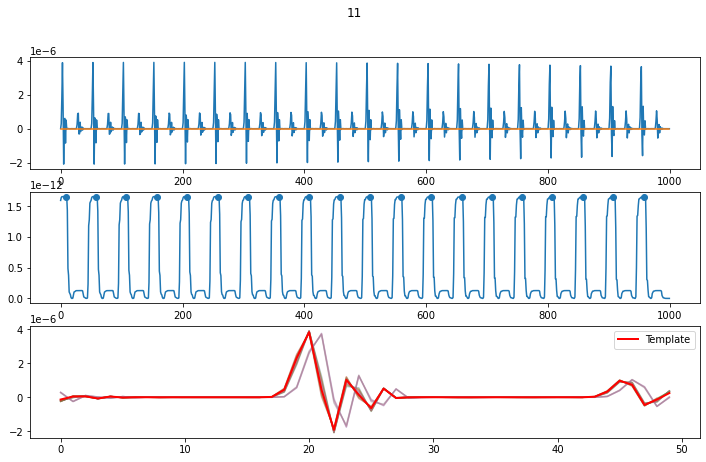

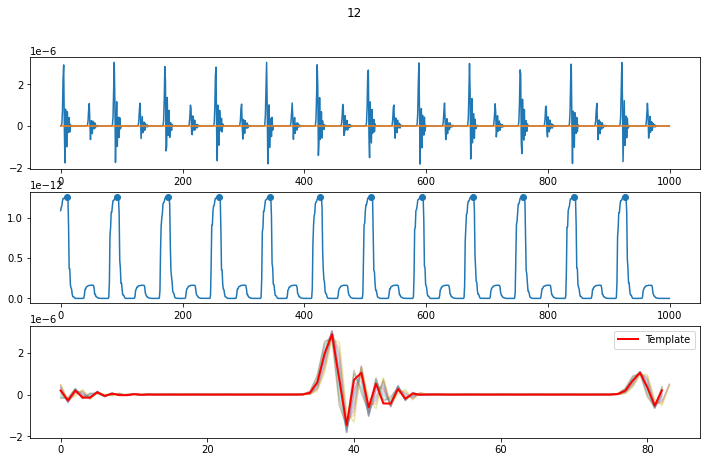

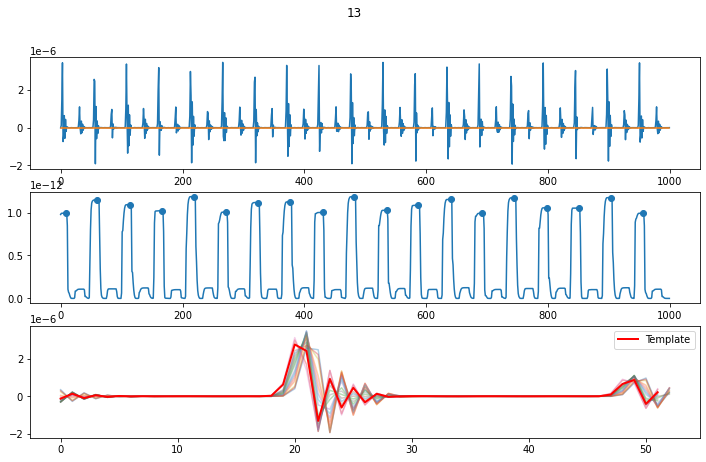

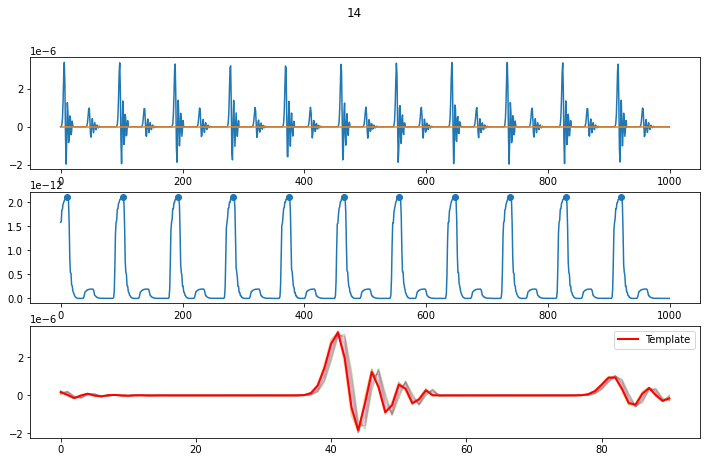

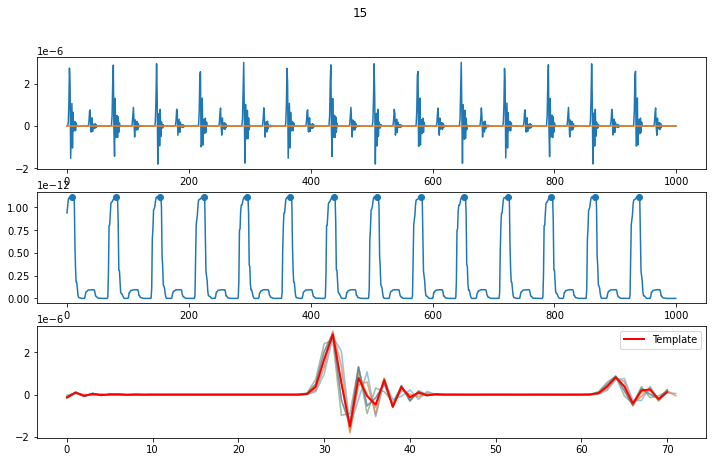

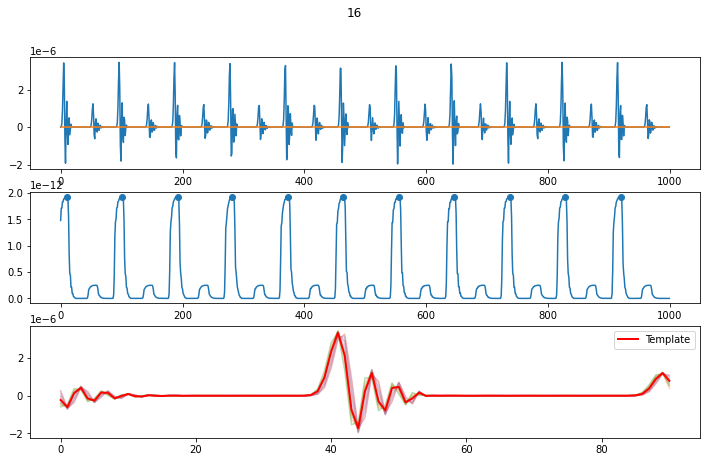

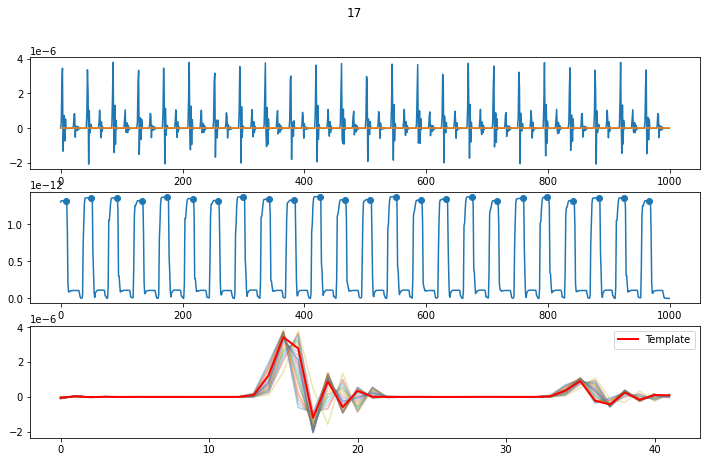

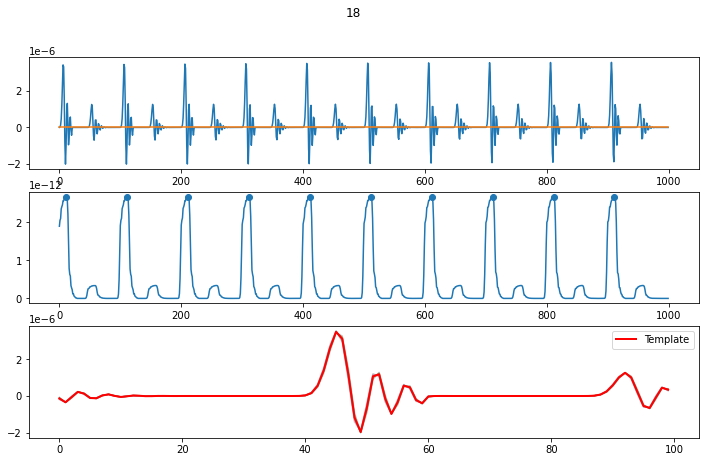

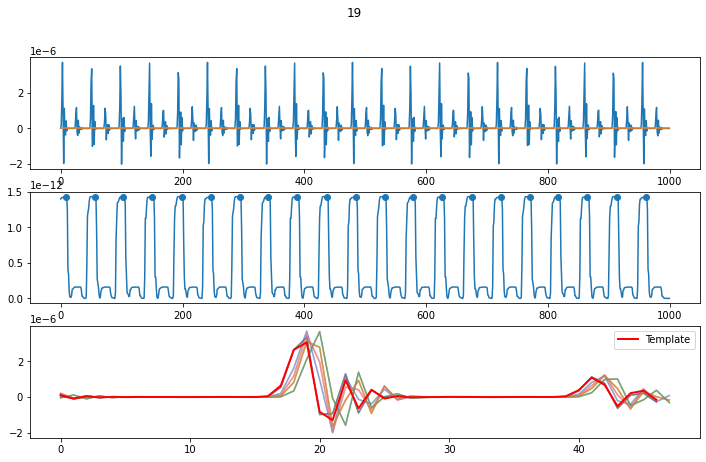

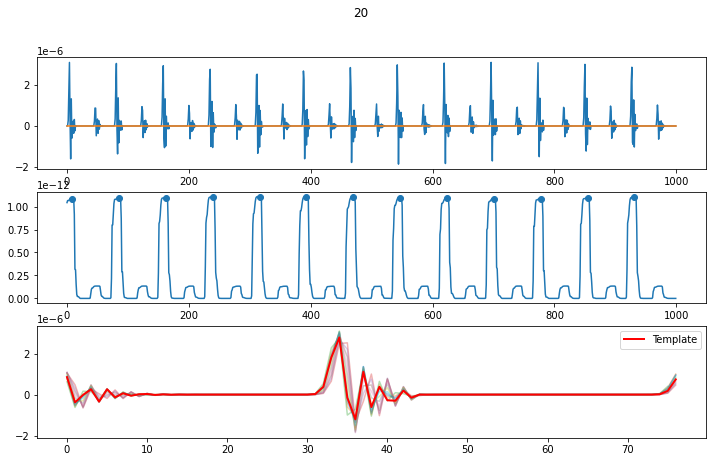

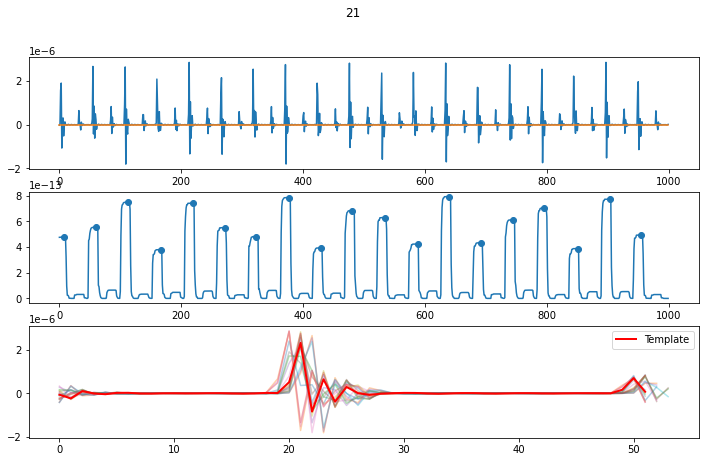

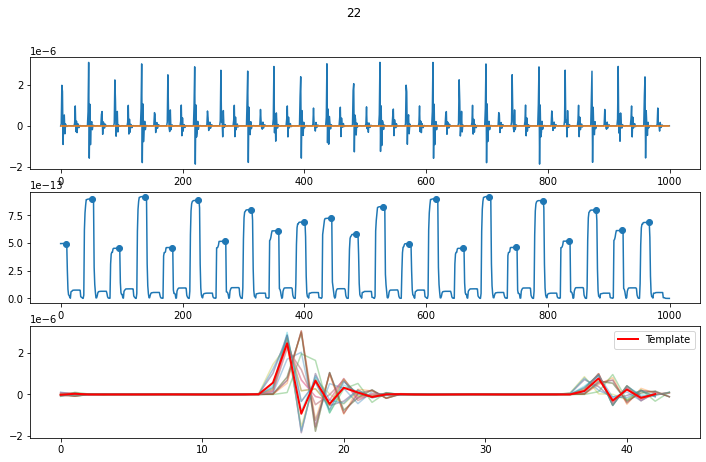

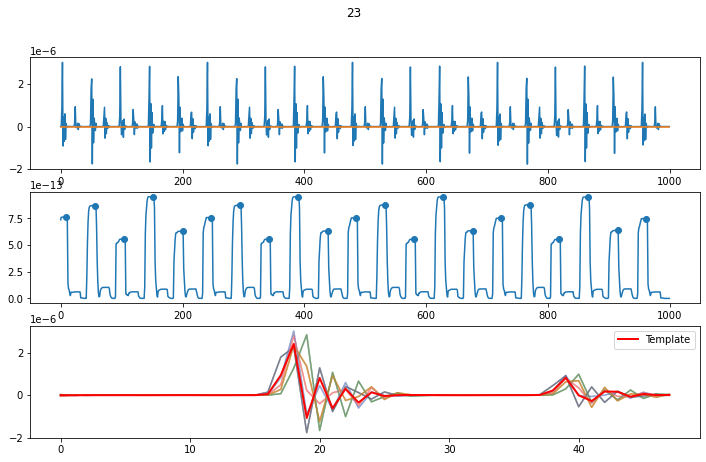

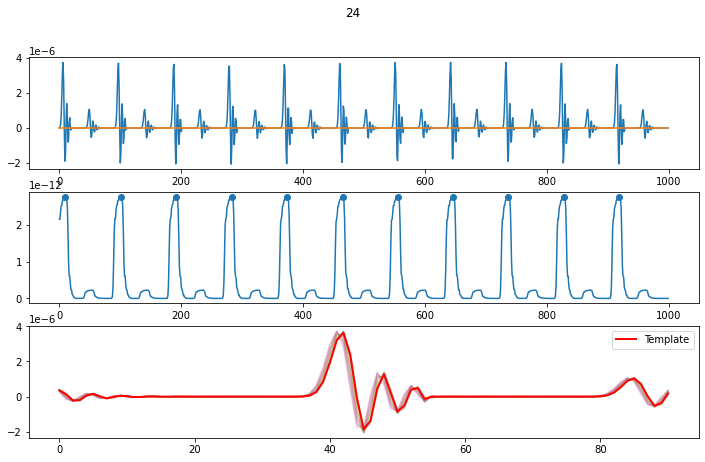

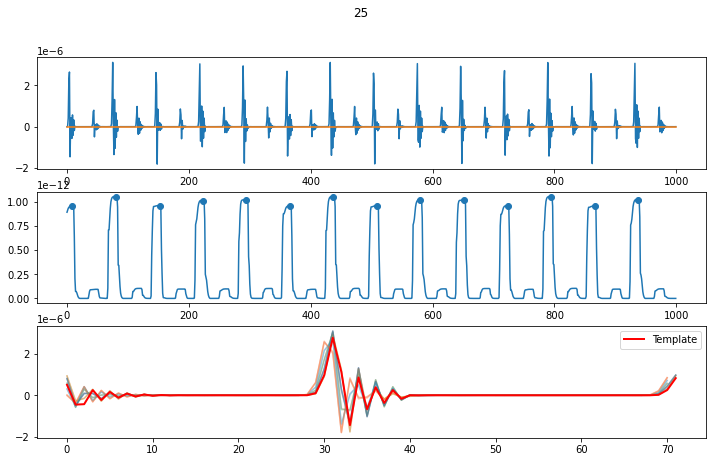

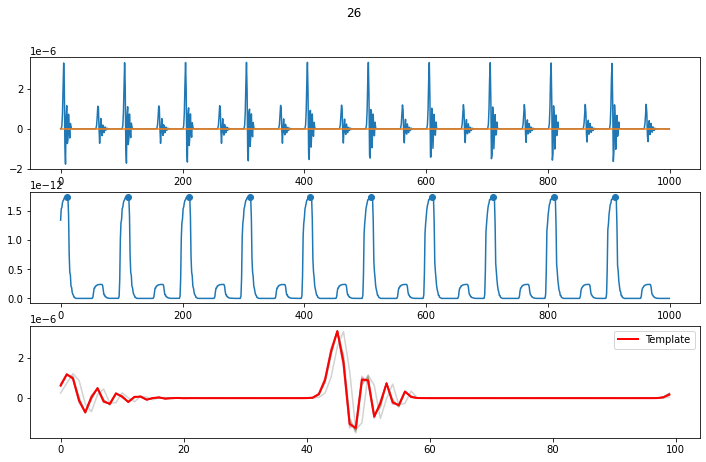

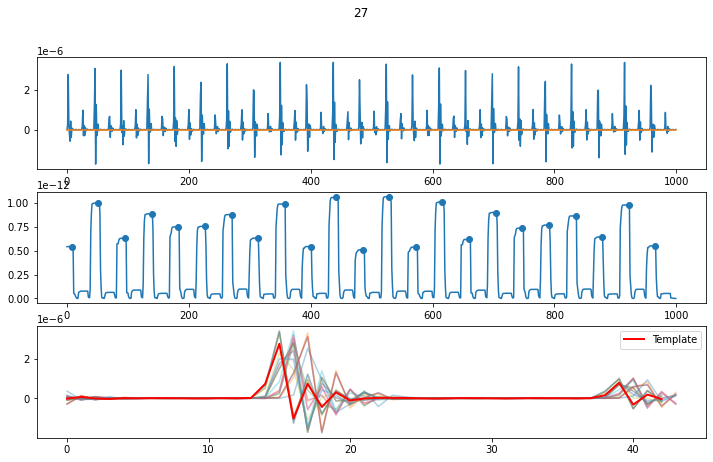

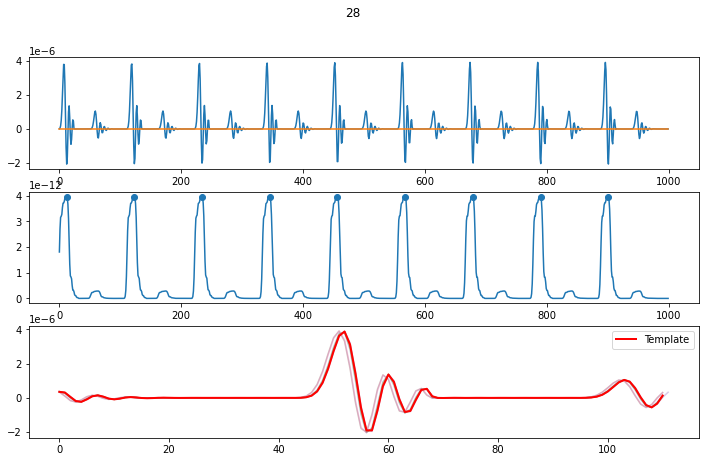

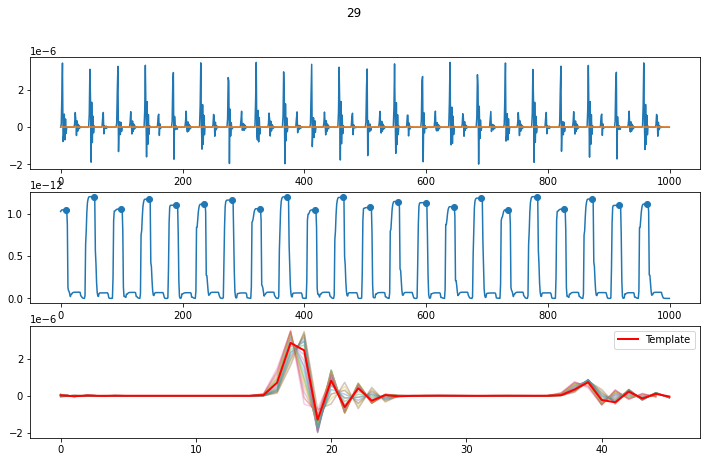

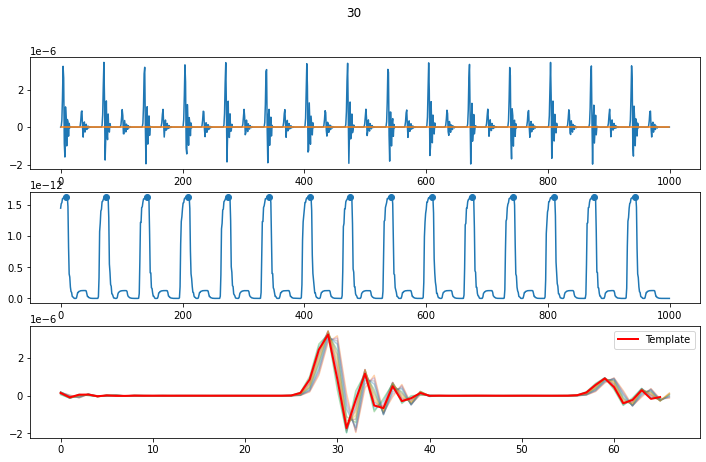

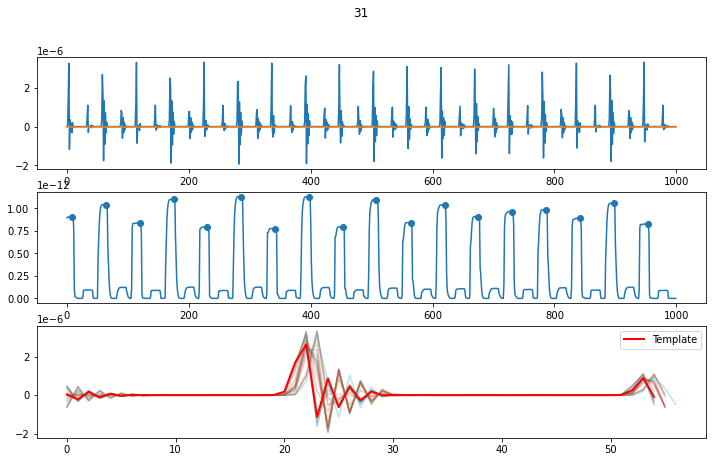

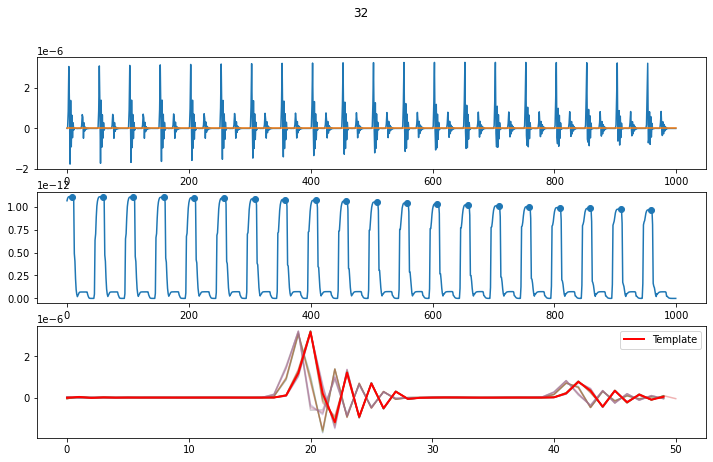

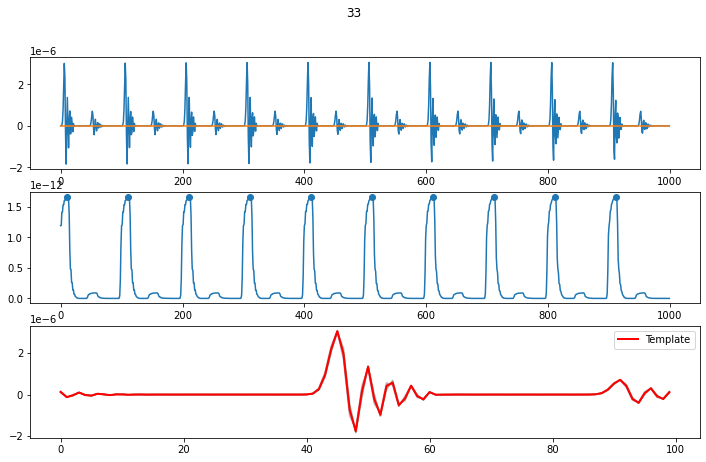

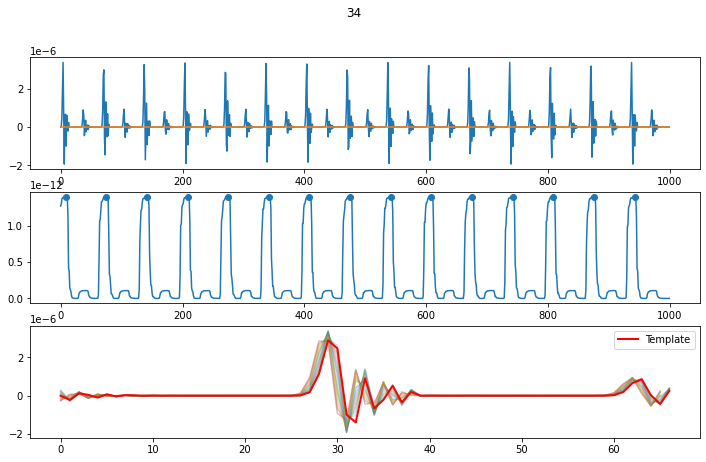

In [109]:
scg_energies = cal_energy(scgs, window=16)
scg_all_pieces_energy = segmentation(scgs, scg_energies, scgs_hrs, 0.2)
plot_segs(scg_energies, scgs, scgs_hrs, scg_all_pieces_energy, 0.2)

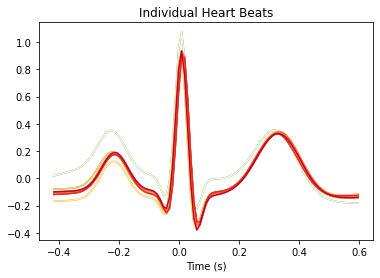

In [94]:
segments = nk.ecg_segment(ecgs[0], rpeaks=None, sampling_rate=100, show=True)